<a href="https://colab.research.google.com/github/ivelin/donut_ui_refexp/blob/main/Inference_Playground_Donut_UI_RefExp_Gradio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://huggingface.co/spaces/ivelin/ui-refexp/

Cloning into 'ui-refexp'...
remote: Enumerating objects: 202, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 202 (delta 7), reused 0 (delta 0), pack-reused 188
Receiving objects: 100% (202/202), 469.83 KiB | 1.93 MiB/s, done.
Resolving deltas: 100% (119/119), done.


In [2]:
!cd ui-refexp/ && pip3 install -r requirements.txt

  Cloning https://github.com/huggingface/transformers.git to /private/var/folders/x6/tdg2_lyn14n9vxhrw5znyrtw0000gn/T/pip-req-build-9buyx1i6
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /private/var/folders/x6/tdg2_lyn14n9vxhrw5znyrtw0000gn/T/pip-req-build-9buyx1i6
  Resolved https://github.com/huggingface/transformers.git to commit c836f77266be9ace47bff472f63caf71c0d11333
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached sentencepiece-0.1.97-cp38-cp38-macosx_10_9_x86_64.whl (1.2 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 kB 2.6 MB/s eta 0:00:00 MB/s eta 0:00:01
  Created wheel for transformers: filename=transformers-4.27.0.dev0-py3-none-any.whl size=6464535 sha256=309196df526399b8830ac0f98fcc502d775ed5e963419f5b04c539cc97c6b19f
  Stored in directory: /private/var/folders/x6/tdg2_lyn14n9vxhrw5znyrtw0000gn/T/pip-e

In [4]:
!pip install gradio


[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: pip install --upgrade pip


In [86]:
import re
import gradio as gr
from PIL import Image, ImageDraw
import math
import torch
import html
from transformers import DonutProcessor, VisionEncoderDecoderModel
import os 

def process_refexp(image: Image, prompt: str, device="mps"):
    os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
#     print(f"(image, prompt): {image}, {prompt}")

    # trim prompt to 80 characters and normalize to lowercase
    prompt = prompt[:80].lower()

    # prepare encoder inputs
    pixel_values = processor(image.convert("RGB"), return_tensors="pt").pixel_values

    # prepare decoder inputs
    task_prompt = "<s_refexp><s_prompt>{user_input}</s_prompt><s_target_bounding_box>"
    prompt = task_prompt.replace("{user_input}", prompt)
    decoder_input_ids = processor.tokenizer(
        prompt, add_special_tokens=False, return_tensors="pt").input_ids
    
    # generate answer
    outputs = model.generate(
        pixel_values.to(device),
        decoder_input_ids=decoder_input_ids.to(device),
        max_length=model.decoder.config.max_position_embeddings,
#         early_stopping=True,
        early_stopping=False,
        pad_token_id=processor.tokenizer.pad_token_id,
        eos_token_id=processor.tokenizer.eos_token_id,
        use_cache=True,
        num_beams=1,
        bad_words_ids=[[processor.tokenizer.unk_token_id]],
        return_dict_in_generate=True,
    )

    # postprocess
    sequence = processor.batch_decode(outputs.sequences)[0]
    print(fr"predicted decoder sequence: {html.escape(sequence)}\n")
    sequence = sequence.replace(processor.tokenizer.eos_token, "").replace(
        processor.tokenizer.pad_token, "")
    # remove first task start token
    sequence = re.sub(r"<.*?>", "", sequence, count=1).strip()
    print(
        fr"predicted decoder sequence before token2json: {html.escape(sequence)}\n\n")
    seqjson = processor.token2json(sequence)

    # safeguard in case predicted sequence does not include a target_bounding_box token
    bbox = seqjson.get('target_bounding_box')
    if bbox is None:
        print(
            f"token2bbox seq has no predicted target_bounding_box, seq:{seq}\n\n")
        bbox = {"xmin": 0, "ymin": 0, "xmax": 0, "ymax": 0}
        return bbox

    print(f"predicted bounding box with text coordinates: {bbox}\n")
    # safeguard in case text prediction is missing some bounding box coordinates
    # or coordinates are not valid numeric values
    try:
        xmin = float(bbox.get("xmin", 0))
    except ValueError:
        xmin = 0
    try:
        ymin = float(bbox.get("ymin", 0))
    except ValueError:
        ymin = 0
    try:
        xmax = float(bbox.get("xmax", 1))
    except ValueError:
        xmax = 1
    try:
        ymax = float(bbox.get("ymax", 1))
    except ValueError:
        ymax = 1
    # replace str with float coords
    bbox = {"xmin": xmin, "ymin": ymin, "xmax": xmax,
            "ymax": ymax, "decoder output sequence": sequence}
#     print(f"predicted bounding box with float coordinates: {bbox}")

#     print(f"image object: {image}")
#     print(f"image size: {image.size}")
    width, height = image.size
    print(f"image width, height: {width, height}\n")
    print(f"processed prompt: {prompt}\n")

    # safeguard in case text prediction is missing some bounding box coordinates
    xmin = math.floor(width*bbox["xmin"])
    ymin = math.floor(height*bbox["ymin"])
    xmax = math.floor(width*bbox["xmax"])
    ymax = math.floor(height*bbox["ymax"])

    print(f"to image pixel values: xmin, ymin, xmax, ymax: {xmin, ymin, xmax, ymax}\n")

    shape = [(xmin, ymin), (xmax, ymax)]

    # deaw bbox rectangle
    img1 = ImageDraw.Draw(image)
    img1.rectangle(shape, outline="green", width=5)
    img1.rectangle(shape, outline="white", width=2)

    return image, bbox

In [87]:
pretrained_repo_name = "ivelin/donut-refexp-combined-v1"
print(f"Loading model checkpoint: {pretrained_repo_name}")

processor = DonutProcessor.from_pretrained(pretrained_repo_name)
model = VisionEncoderDecoderModel.from_pretrained(pretrained_repo_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# model.to("mps")
# os.putenv("PYTORCH_ENABLE_MPS_FALLBACK", "1")
# print("model loaded and moved to mps")
# processor()

Loading model checkpoint: ivelin/donut-refexp-combined-v1
model loaded and moved to mps


predicted decoder sequence: &lt;s_refexp&gt;&lt;s_prompt&gt; click on the plus, &#x27;+&#x27; icon in the bottom left corner&lt;/s_prompt&gt;&lt;s_target_bounding_box&gt;&lt;s_xmax&gt; 0.12&lt;/s_xmax&gt;&lt;s_xmin&gt; 0.0&lt;/s_xmin&gt;&lt;s_ymax&gt; 0.93&lt;/s_ymax&gt;&lt;s_ymin&gt; 0.91&lt;/s_ymin&gt;&lt;/s_target_bounding_box&gt;&lt;/s&gt;\n
predicted decoder sequence before token2json: &lt;s_prompt&gt; click on the plus, &#x27;+&#x27; icon in the bottom left corner&lt;/s_prompt&gt;&lt;s_target_bounding_box&gt;&lt;s_xmax&gt; 0.12&lt;/s_xmax&gt;&lt;s_xmin&gt; 0.0&lt;/s_xmin&gt;&lt;s_ymax&gt; 0.93&lt;/s_ymax&gt;&lt;s_ymin&gt; 0.91&lt;/s_ymin&gt;&lt;/s_target_bounding_box&gt;\n\n
predicted bounding box with text coordinates: {'xmax': '0.12', 'xmin': '0.0', 'ymax': '0.93', 'ymin': '0.91'}

image width, height: (828, 1792)

processed prompt: <s_refexp><s_prompt>click on the plus, '+' icon in the bottom left corner</s_prompt><s_target_bounding_box>

to image pixel values: xmin, ymin, xma

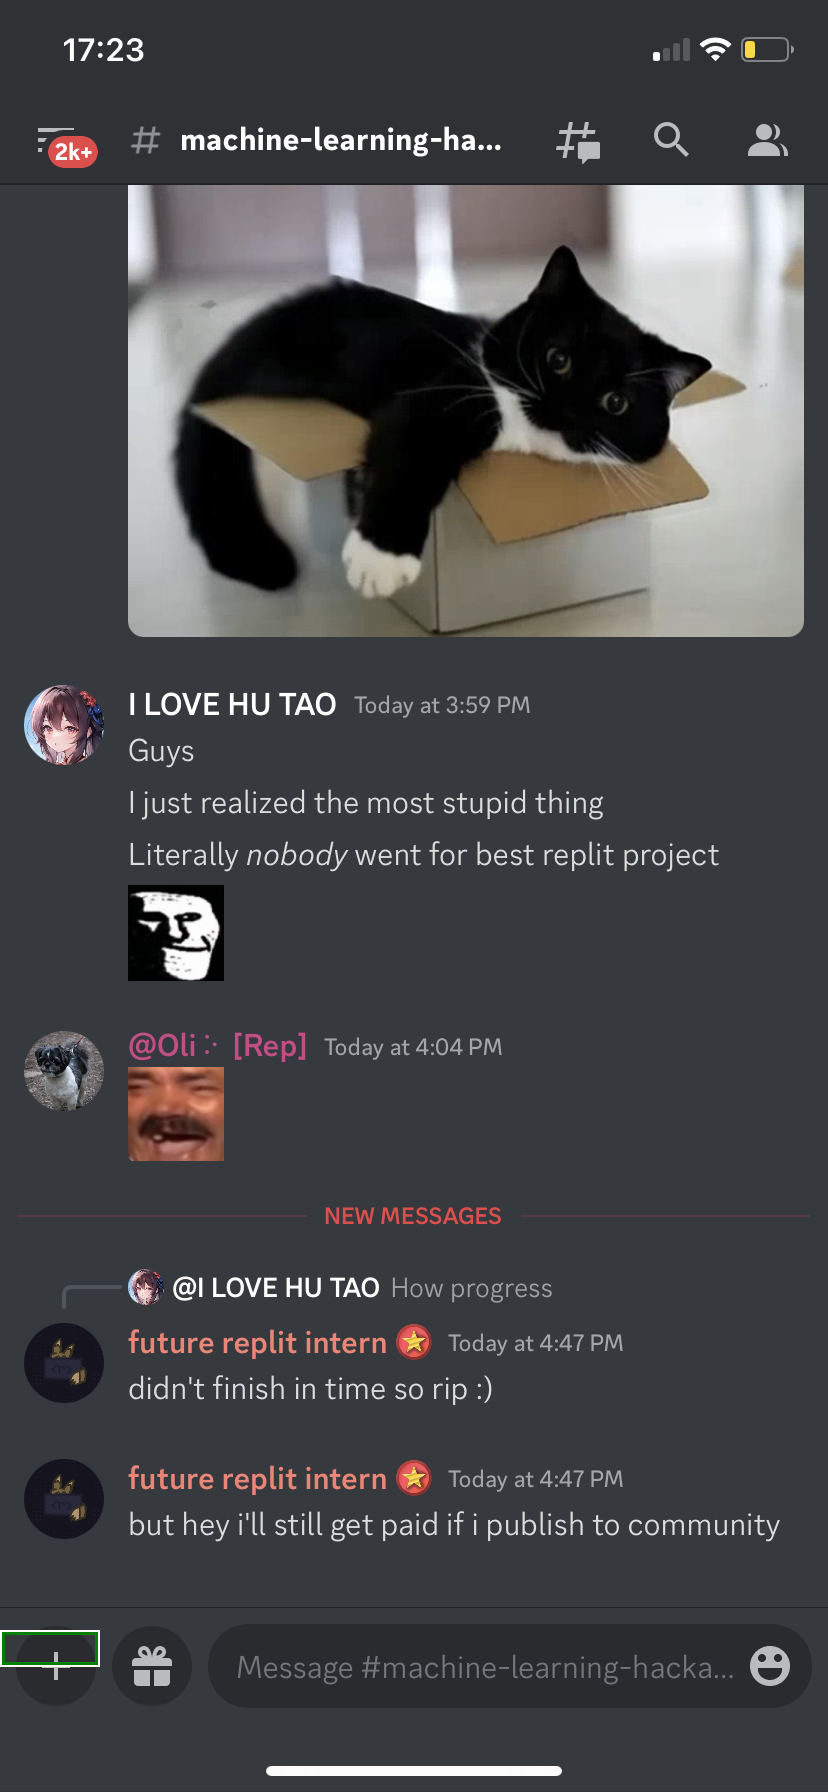

In [89]:
from PIL import Image, ImageDraw
# open image file

# im = Image.open("discord_ss.png")
im = Image.open("discord_mobile_ss.jpeg")
width, height = im.size

prompt = "click on the plus, '+' icon in the bottom left corner"

image, bbox = process_refexp(im, prompt, device=device)
image

In [81]:
# xmin = bbox["xmin"]
# ymin = bbox["ymin"]
# xmax = bbox["xmax"]
# ymax = bbox["ymax"]

# print(f"to image pixel values: xmin, ymin, xmax, ymax: {xmin, ymin, xmax, ymax}")

# shape = [(xmin, ymin), (xmax, ymax)]

# # create rectangle image
# img1 = ImageDraw.Draw(im)  
# img1.rectangle(shape, outline ="green", width=5)
# image.resize((int(width*0.5), int(height*0.5)))

In [33]:
# title = "Demo: Donut 🍩 for UI RefExp (by GuardianUI)"
# description = "Gradio Demo for Donut RefExp task, an instance of `VisionEncoderDecoderModel` fine-tuned on [UIBert RefExp](https://huggingface.co/datasets/ivelin/ui_refexp_saved) Dataset (UI Referring Expression). To use it, simply upload your image and type a prompt and click 'submit', or click one of the examples to load them. See the model training <a href='https://colab.research.google.com/github/ivelin/donut_ui_refexp/blob/main/Fine_tune_Donut_on_UI_RefExp.ipynb' target='_parent'>Colab Notebook</a> for this space. Read more at the links below."
# article = "<p style='text-align: center'><a href='https://arxiv.org/abs/2111.15664' target='_blank'>Donut: OCR-free Document Understanding Transformer</a> | <a href='https://github.com/clovaai/donut' target='_blank'>Github Repo</a></p>"
# examples = [["example_1.jpg", "select the setting icon from top right corner"],
#             ["example_1.jpg", "click on down arrow beside the entertainment"],
#             ["example_1.jpg", "select the down arrow button beside lifestyle"],
#             ["example_1.jpg", "click on the image beside the option traffic"],
#             ["example_2.jpg", "enter the text field next to the name"],
#             ["example_2.jpg", "click on green color button"],
#             ["example_2.jpg", "click on text which is beside call now"],
#             ["example_2.jpg", "click on more button"],
#             ["example_3.jpg", "select the third row first image"],
#             ["example_3.jpg", "click the tick mark on the first image"],
#             ["example_3.jpg", "select the ninth image"],
#             ["example_3.jpg", "select the add icon"],
#             ["example_3.jpg", "click the first image"],
#             ["val-image-1.jpg", "select calendar option"],
#             ["val-image-1.jpg", "select photos&videos option"],
#             ["val-image-2.jpg", "click on change store"],
#             ["val-image-2.jpg", "click on shop menu at the bottom"],
#             ["val-image-3.jpg", "click on image above short meow"],
#             ["val-image-3.jpg", "go to cat sounds"],
#             ]

# demo = gr.Interface(fn=process_refexp,
#                     inputs=[gr.Image(type="pil"), "text"],
#                     outputs=[gr.Image(type="pil"), "json"],
#                     title=title,
#                     description=description,
#                     article=article,
#                     # examples=examples,
#                     # caching examples inference takes too long to start space after app change commit
#                     cache_examples=False
#                     )

# demo.launch(share=True)

In [28]:
im = Image.open("discord_ss.png")
processor(im.convert("RGB"), return_tensors="pt").pixel_values.shape

torch.Size([1, 3, 1280, 960])

In [3]:
# from transformers import DonutProcessor, VisionEncoderDecoderModel

In [4]:
# import re
# import gradio as gr
# from PIL import Image, ImageDraw
# import math
# import torch
# import html
# from transformers import DonutProcessor, VisionEncoderDecoderModel

# pretrained_repo_name = "ivelin/donut-refexp-combined-v1"
# print(f"Loading processor: {pretrained_repo_name}")
# processor = DonutProcessor.from_pretrained(pretrained_repo_name)

# print(f"Loading model checkpoint: {pretrained_repo_name}")
# model = VisionEncoderDecoderModel.from_pretrained(pretrained_repo_name)

Loading processor: ivelin/donut-refexp-combined-v1


Loading model checkpoint: ivelin/donut-refexp-combined-v1


In [5]:
# device = "cuda" if torch.cuda.is_available() else "cpu"
# model.to("mps")

VisionEncoderDecoderModel(
  (encoder): DonutSwinModel(
    (embeddings): DonutSwinEmbeddings(
      (patch_embeddings): DonutSwinPatchEmbeddings(
        (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DonutSwinEncoder(
      (layers): ModuleList(
        (0): DonutSwinStage(
          (blocks): ModuleList(
            (0): DonutSwinLayer(
              (layernorm_before): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (attention): DonutSwinAttention(
                (self): DonutSwinSelfAttention(
                  (query): Linear(in_features=128, out_features=128, bias=True)
                  (key): Linear(in_features=128, out_features=128, bias=True)
                  (value): Linear(in_features=128, out_features=128, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
                )